<a href="https://colab.research.google.com/github/sanjanabontha/SKMLI-175-TASKS/blob/main/Phase3(Task3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 0.33
Classification Report:
               precision    recall  f1-score   support

    disease1       0.37      0.30      0.33        69
    disease2       0.31      0.35      0.33        62
    disease3       0.32      0.33      0.33        69

    accuracy                           0.33       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.33      0.33      0.33       200



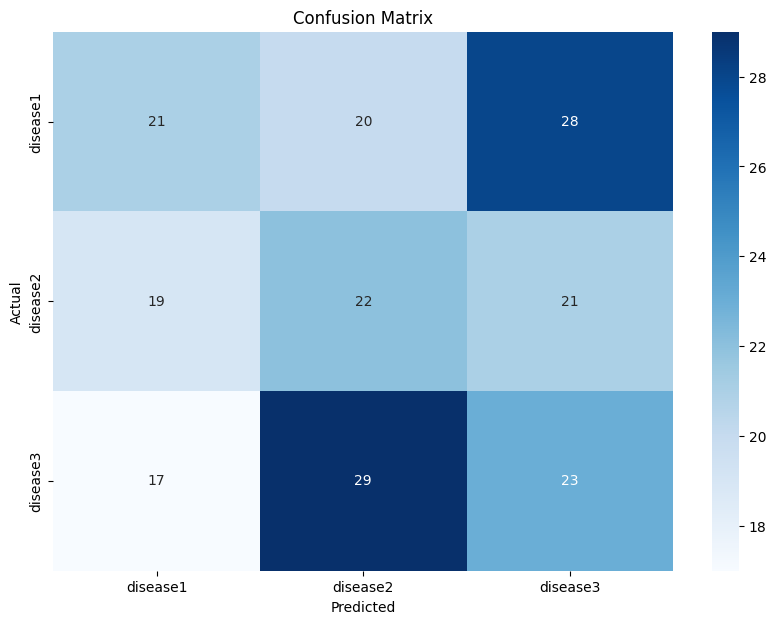

Best Model Accuracy: 0.37
Best Model Classification Report:
               precision    recall  f1-score   support

    disease1       0.42      0.30      0.35        69
    disease2       0.35      0.45      0.40        62
    disease3       0.35      0.36      0.36        69

    accuracy                           0.37       200
   macro avg       0.38      0.37      0.37       200
weighted avg       0.38      0.37      0.37       200



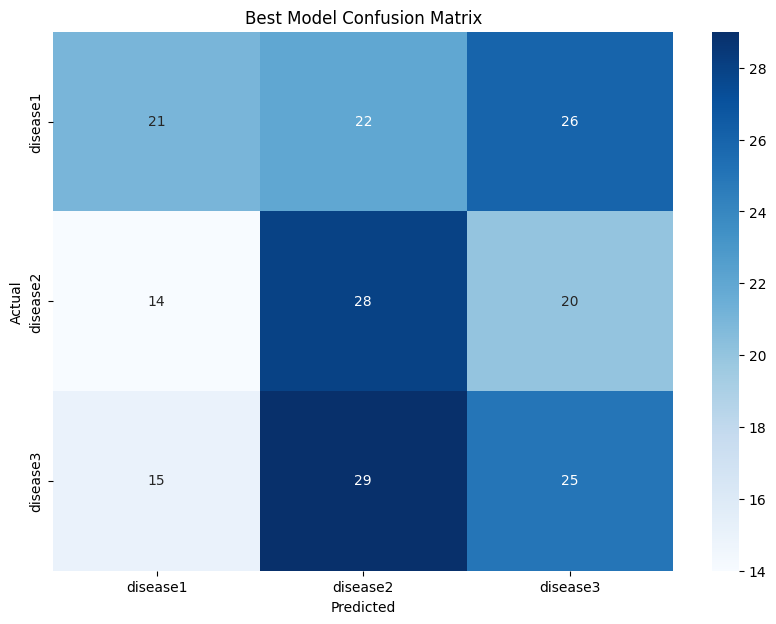

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Generate synthetic data
np.random.seed(42)
n_samples = 1000

# Features
age = np.random.randint(18, 70, size=n_samples)
bmi = np.random.uniform(18.5, 35, size=n_samples)
symptom1 = np.random.randint(0, 2, size=n_samples)  # Binary feature
symptom2 = np.random.randint(0, 2, size=n_samples)  # Binary feature
symptom_category = np.random.choice(['A', 'B', 'C'], size=n_samples)
gender = np.random.choice(['male', 'female'], size=n_samples)

# Target variable (disease)
disease = np.random.choice(['disease1', 'disease2', 'disease3'], size=n_samples)

# Create DataFrame
data = pd.DataFrame({
    'age': age,
    'bmi': bmi,
    'symptom1': symptom1,
    'symptom2': symptom2,
    'symptom_category': symptom_category,
    'gender': gender,
    'disease': disease
})

# Step 2: Data Preprocessing
# Handle missing values (none in synthetic data but included for completeness)
data.ffill(inplace=True)

# Step 4: Feature Engineering
# Convert categorical features to numerical
data['symptom_category'] = data['symptom_category'].astype('category')
data['symptom_category_code'] = data['symptom_category'].cat.codes

# Create interaction features if necessary
data['symptom1_symptom2_interaction'] = data['symptom1'] * data['symptom2']

# Scale numerical features
numerical_features = ['age', 'bmi']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Encode categorical features
categorical_features = ['symptom_category', 'gender']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(data[categorical_features])

# Create DataFrame for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Combine encoded features with the original DataFrame
data = pd.concat([data, encoded_df], axis=1)
data.drop(categorical_features, axis=1, inplace=True)  # Drop original categorical features

# Prepare features and target variable for model
features = [col for col in data.columns if col != 'disease']
X = data[features]
y = data['disease']

# Step 5: Model Selection and Step 6: Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Model Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 8: Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Best Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 9: Prediction
# Example of predicting the disease for new symptom data
new_symptoms = pd.DataFrame({
    'age': [30, 45],
    'bmi': [22.0, 28.5],
    'symptom1': [0, 1],
    'symptom2': [1, 0],
    'symptom_category': ['B', 'A'],  # Use original categories
    'gender': ['male', 'female']     # Use original gender values
})

# Apply preprocessing steps to new data
# Encode categorical features (same way as training data)
new_encoded_features = encoder.transform(new_symptoms[categorical_features])

# Get the actual feature names generated by the encoder for new data
new_encoded_feature_names = encoder.get_feature_names_out(categorical_features)

new_encoded_df = pd.DataFrame(new_encoded_features, columns=new_encoded_feature_names)

# Combine encoded features and drop original categorical columns
new_symptoms = pd.concat([new_symptoms, new_encoded_df], axis=1)
new_symptoms.drop(categorical_features, axis=1, inplace=True)

# Generate 'symptom_category_code' for new data
# Use the dynamically generated column names for idxmax
new_symptoms['symptom_category_code'] = new_symptoms[new_encoded_feature_names].idxmax(axis=1).apply(lambda x: 0 if x == new_encoded_feature_names[0] else (1 if x == new_encoded_feature_names[1] else 2))

# Create interaction feature (if it was used during training)
new_symptoms['symptom1_symptom2_interaction'] = new_symptoms['symptom1'] * new_symptoms['symptom2']

# Make predictions
predictions = best_model.predict(new_symptoms)
print('Predictions for New Symptoms:', predictions)

# Step 10: Deployment
# Save the model to a file
joblib.dump(best_model, 'health_disease_predictor.pkl')

# Example of loading the model and making predictions
loaded_model = joblib.load('health_disease_predictor.pkl')
example_symptoms = pd.DataFrame({
    'age': [25],
    'bmi': [23.0],
    'symptom1': [1],
    'symptom2': [0],
    'symptom_category_code': [0],
    'gender_male': [1],
    'gender_female': [0],
    'symptom1_symptom2_interaction': [0]
})
example_symptom_scaled = example_symptoms.copy()
example_symptom_scaled[numerical_features] = scaler.transform(example_symptoms[numerical_features])
example_prediction = loaded_model.predict(example_symptom_scaled)
print('Example Prediction:', example_prediction)


Accuracy: 0.315
Classification Report:
               precision    recall  f1-score   support

    disease1       0.34      0.28      0.30        69
    disease2       0.32      0.37      0.34        62
    disease3       0.30      0.30      0.30        69

    accuracy                           0.32       200
   macro avg       0.32      0.32      0.31       200
weighted avg       0.32      0.32      0.31       200



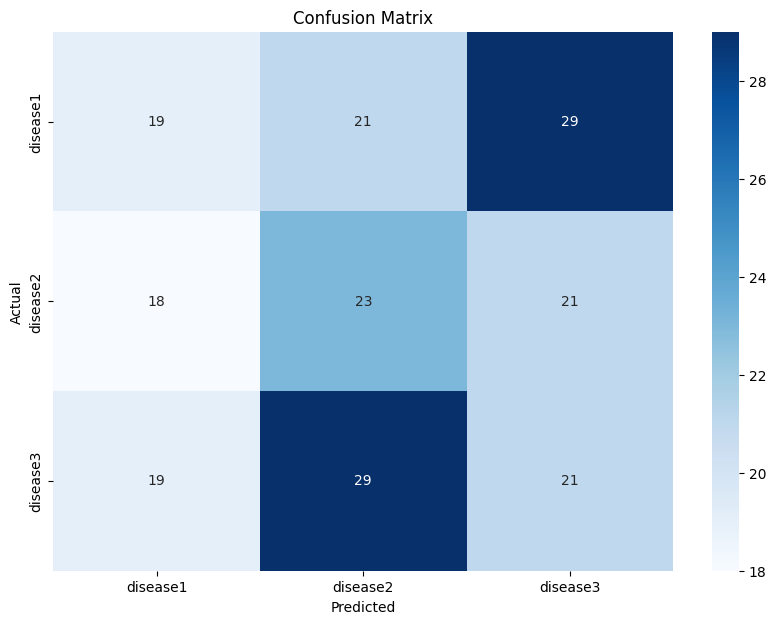

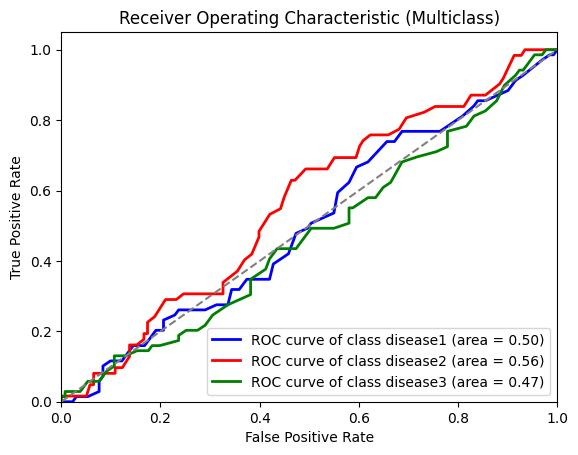


Best Model Accuracy: 0.315
Best Model Classification Report:
               precision    recall  f1-score   support

    disease1       0.34      0.23      0.28        69
    disease2       0.31      0.39      0.34        62
    disease3       0.31      0.33      0.32        69

    accuracy                           0.32       200
   macro avg       0.32      0.32      0.31       200
weighted avg       0.32      0.32      0.31       200



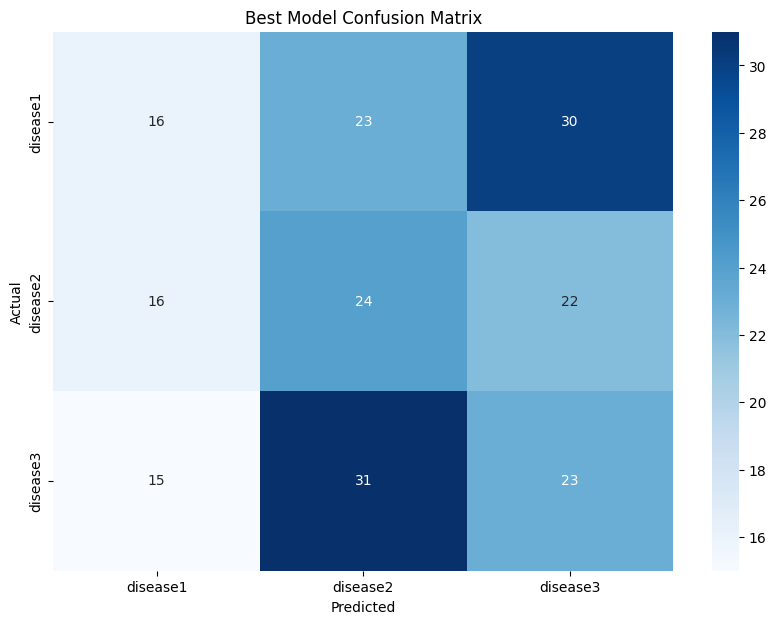

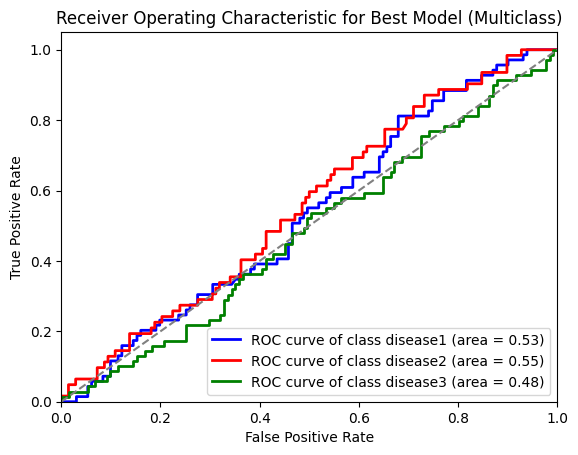


Predictions for New Symptoms: ['disease1' 'disease1']
Example Prediction: ['disease1']


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Generate synthetic data
np.random.seed(42)
n_samples = 1000

# Features
age = np.random.randint(18, 70, size=n_samples)
bmi = np.random.uniform(18.5, 35, size=n_samples)
symptom1 = np.random.randint(0, 2, size=n_samples)  # Binary feature
symptom2 = np.random.randint(0, 2, size=n_samples)  # Binary feature
symptom_category = np.random.choice(['A', 'B', 'C'], size=n_samples)
gender = np.random.choice(['male', 'female'], size=n_samples)

# Target variable (disease)
disease = np.random.choice(['disease1', 'disease2', 'disease3'], size=n_samples)

# Create DataFrame
data = pd.DataFrame({
    'age': age,
    'bmi': bmi,
    'symptom1': symptom1,
    'symptom2': symptom2,
    'symptom_category': symptom_category,
    'gender': gender,
    'disease': disease
})

# Step 2: Data Preprocessing
# Handle missing values (none in synthetic data but included for completeness)
data.ffill(inplace=True)  # Use ffill() instead of fillna(method='ffill')

# Define feature and target columns
features = ['age', 'bmi', 'symptom1', 'symptom2', 'symptom_category', 'gender']
target = 'disease'

# Convert categorical features to numerical
data['symptom_category'] = data['symptom_category'].astype('category')
data['symptom_category_code'] = data['symptom_category'].cat.codes

# Define the preprocessing steps
numerical_features = ['age', 'bmi']
categorical_features = ['symptom_category', 'gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Prepare features and target variable for model
X = data[features]
y = data[target]

# Convert target variable to binary for ROC curve (example for binary classification)
lb = LabelBinarizer()
y_binary = lb.fit_transform(y).ravel()  # Convert to binary

# Step 5: Model Selection and Step 6: Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

# Step 7: Model Evaluation
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("\n")

# ROC Curve Plotting
y_prob = pipeline.predict_proba(X_test)
y_test_bin = lb.transform(y_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(lb.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multiclass)')
plt.legend(loc='lower right')
plt.show()

# Step 8: Hyperparameter Tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("\nBest Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Best Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("\n")

# ROC Curve Plotting for Best Model
y_prob_best = best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_best[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(lb.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Best Model (Multiclass)')
plt.legend(loc='lower right')
plt.show()

# Step 9: Prediction
# Example of predicting the disease for new symptom data
new_symptoms = pd.DataFrame({
    'age': [30, 45],
    'bmi': [22.0, 28.5],
    'symptom1': [0, 1],
    'symptom2': [1, 0],
    'symptom_category': ['B', 'A'],
    'gender': ['male', 'female']
})

# Make predictions using the pipeline (get probabilities)
# Use 'predict_proba' to get probabilities for each class
predictions_proba = pipeline.predict_proba(new_symptoms)

# Determine predicted class based on highest probability
# Reshape predicted_classes to be a 2D array
predicted_classes = np.argmax(predictions_proba, axis=1).reshape(-1, 1)

# Inverse transform the predicted class indices to get disease labels
predicted_diseases = lb.inverse_transform(predicted_classes)
print('\nPredictions for New Symptoms:', predicted_diseases)

# Step 10: Deployment
# Save the model to a file
joblib.dump(best_model, 'health_disease_predictor.pkl')

# Example of loading the model and making predictions
loaded_model = joblib.load('health_disease_predictor.pkl')
example_symptoms = pd.DataFrame({
    'age': [25],
    'bmi': [23.0],
    'symptom1': [1],
    'symptom2': [0],
    'symptom_category': ['A'],
    'gender': ['male']
})
example_prediction = loaded_model.predict(example_symptoms)

# Reshape the prediction to a 2D array before inverse transforming
example_prediction_reshaped = example_prediction.reshape(-1, 1)
print('Example Prediction:', lb.inverse_transform(example_prediction_reshaped))


   Symptom_1  Symptom_2  Symptom_3  Symptom_4  Symptom_5  Disease
0          0          1          0          1          1        0
1          1          0          1          1          0        1
2          0          0          1          1          0        1
3          0          0          1          1          0        1
4          0          0          1          0          1        1
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       134
           1       0.92      0.86      0.89       166

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



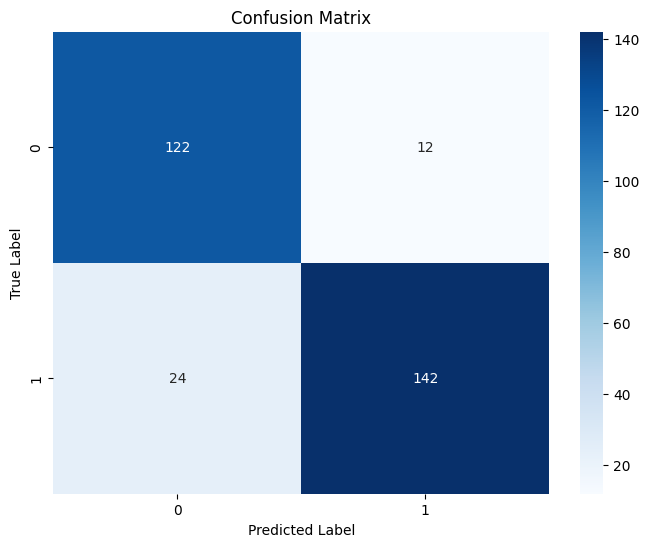

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_samples = 1000

# Generate random features (symptoms)
symptom_1 = np.random.randint(0, 2, size=n_samples)
symptom_2 = np.random.randint(0, 2, size=n_samples)
symptom_3 = np.random.randint(0, 2, size=n_samples)
symptom_4 = np.random.randint(0, 2, size=n_samples)
symptom_5 = np.random.randint(0, 2, size=n_samples)

# Generate diseases with some noise
disease = (symptom_1 & symptom_2 | symptom_3 & symptom_4 | symptom_5 & np.random.randint(0, 2, size=n_samples)).astype(int)

# Create a DataFrame
df = pd.DataFrame({
    'Symptom_1': symptom_1,
    'Symptom_2': symptom_2,
    'Symptom_3': symptom_3,
    'Symptom_4': symptom_4,
    'Symptom_5': symptom_5,
    'Disease': disease
})

# Display first few rows of the dataframe
print(df.head())

# Define features and target variable
X = df[['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5']]
y = df['Disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
